# Setup

Data

hoop

0. OR_wx[active_slice]
1. OR_wy[active_slice]
2. OR_wz[active_slice]

femur

3. IB_wx[active_slice]
4. IB_wy[active_slice]
5. IB_wz[active_slice]

tibia

6. IT_wx[active_slice]
7. IT_wy[active_slice]
8. IT_wz[active_slice]

cuneiform

9. IL_wx[active_slice]
10. IL_wy[active_slice]
11. IL_wz[active_slice]




## Packages

In [1]:
import sys
import os

# 1. Get the directory of the current notebook/script.
# If running a notebook in the same directory as network_computation.py, 
# os.getcwd() will point to the correct Parent Directory.
current_dir = os.getcwd() 

# You can also use the hardcoded parent path for absolute certainty:
# current_dir = '/Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/network-methods-code/2024-code-ExploringLocalizationInNonlinearOscillators/'

# 2. Add this directory to the Python path if it's not already there.
if current_dir not in sys.path:
    sys.path.append(current_dir)
    print(f"Added the project directory to sys.path: {current_dir}")

Added the project directory to sys.path: /Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/network-methods-code/2024-code-ExploringLocalizationInNonlinearOscillators


In [2]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from process_movella import load_movella
from network_computation import compute_functional_network
from utilities_network_additional import plot_rotation_networks, save_network_arrays, get_sliding_window_animation, plot_rotation_heatmaps, plot_positive_directional_differences

## Data

In [3]:
# Defining input and output directory

IN_DIR = Path("/Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/experiments/Hula Hoop/2025-09-03 Experiment 5/2025-09-03 Euler Angles")
OUT_DIR = Path("out")

# make the output directory if it does not exist
if not OUT_DIR.exists():
    OUT_DIR.mkdir()

# Reading sensor data

# OR: hoop
# IB: femur
# IT: tibia
# IL: cuneiform

h_hoop_file = IN_DIR / "OR_20250903_203926.csv"
t_hoop_file = IN_DIR / "IT_20250903_203926.csv"
c_hoop_file = IN_DIR / "IL_20250903_203926.csv"
f_hoop_file = IN_DIR / "IB_20250903_203926.csv"

lead_time_val = 0
h_hoop_data = load_movella(h_hoop_file, lead_time=lead_time_val)
t_hoop_data = load_movella(t_hoop_file, lead_time=lead_time_val)
c_hoop_data = load_movella(c_hoop_file, lead_time=lead_time_val)
f_hoop_data = load_movella(f_hoop_file, lead_time=lead_time_val)

time, _, _, _, h_phi, h_theta, h_psi, h_wx, h_wy, h_wz = h_hoop_data.T
_, _, _, _, t_phi, t_theta, t_psi, t_wx, t_wy, t_wz = t_hoop_data.T
_, _, _, _, c_phi, c_theta, c_psi, c_wx, c_wy, c_wz = c_hoop_data.T
_, _, _, _, f_phi, f_theta, f_psi, f_wx, f_wy, f_wz = f_hoop_data.T

# Derivatives of psi of hoop
h_dpsi_dt = np.sin(h_phi)/np.cos(h_theta)*h_wy+np.cos(h_phi)/np.cos(h_theta)*h_wz

data = np.vstack([time, h_dpsi_dt, time, f_wx, time, f_wy, time, f_wz, time, t_wx, time, t_wy, time, t_wz, time, c_wx, time, c_wy, time, c_wz]).T

# cutting to active region
data = data[694:2588,:]

In [4]:
SAVE = False
FOLDER = "/Users/theresahonein/Desktop/terryhonein/Research-HulaHoop/network-methods-code/2024-code-ExploringLocalizationInNonlinearOscillators/theresa_rotation_results"


# Network Analysis On complete data - One Shot

In [5]:
%%capture
print("this will not show")
_, _, _, _, _, C_xys, C_yxs, T_xys, T_yxs = compute_functional_network(data, rr=(0.03, 0.03, 0.02), n=10 )

In [6]:
np.shape(data)

(1894, 20)

In [7]:
if SAVE == True:
    save_network_arrays(
        FOLDER,
        data=data,
        C_xys=C_xys,
        C_yxs=C_yxs,
        T_xys=T_xys,
        T_yxs=T_yxs
    )

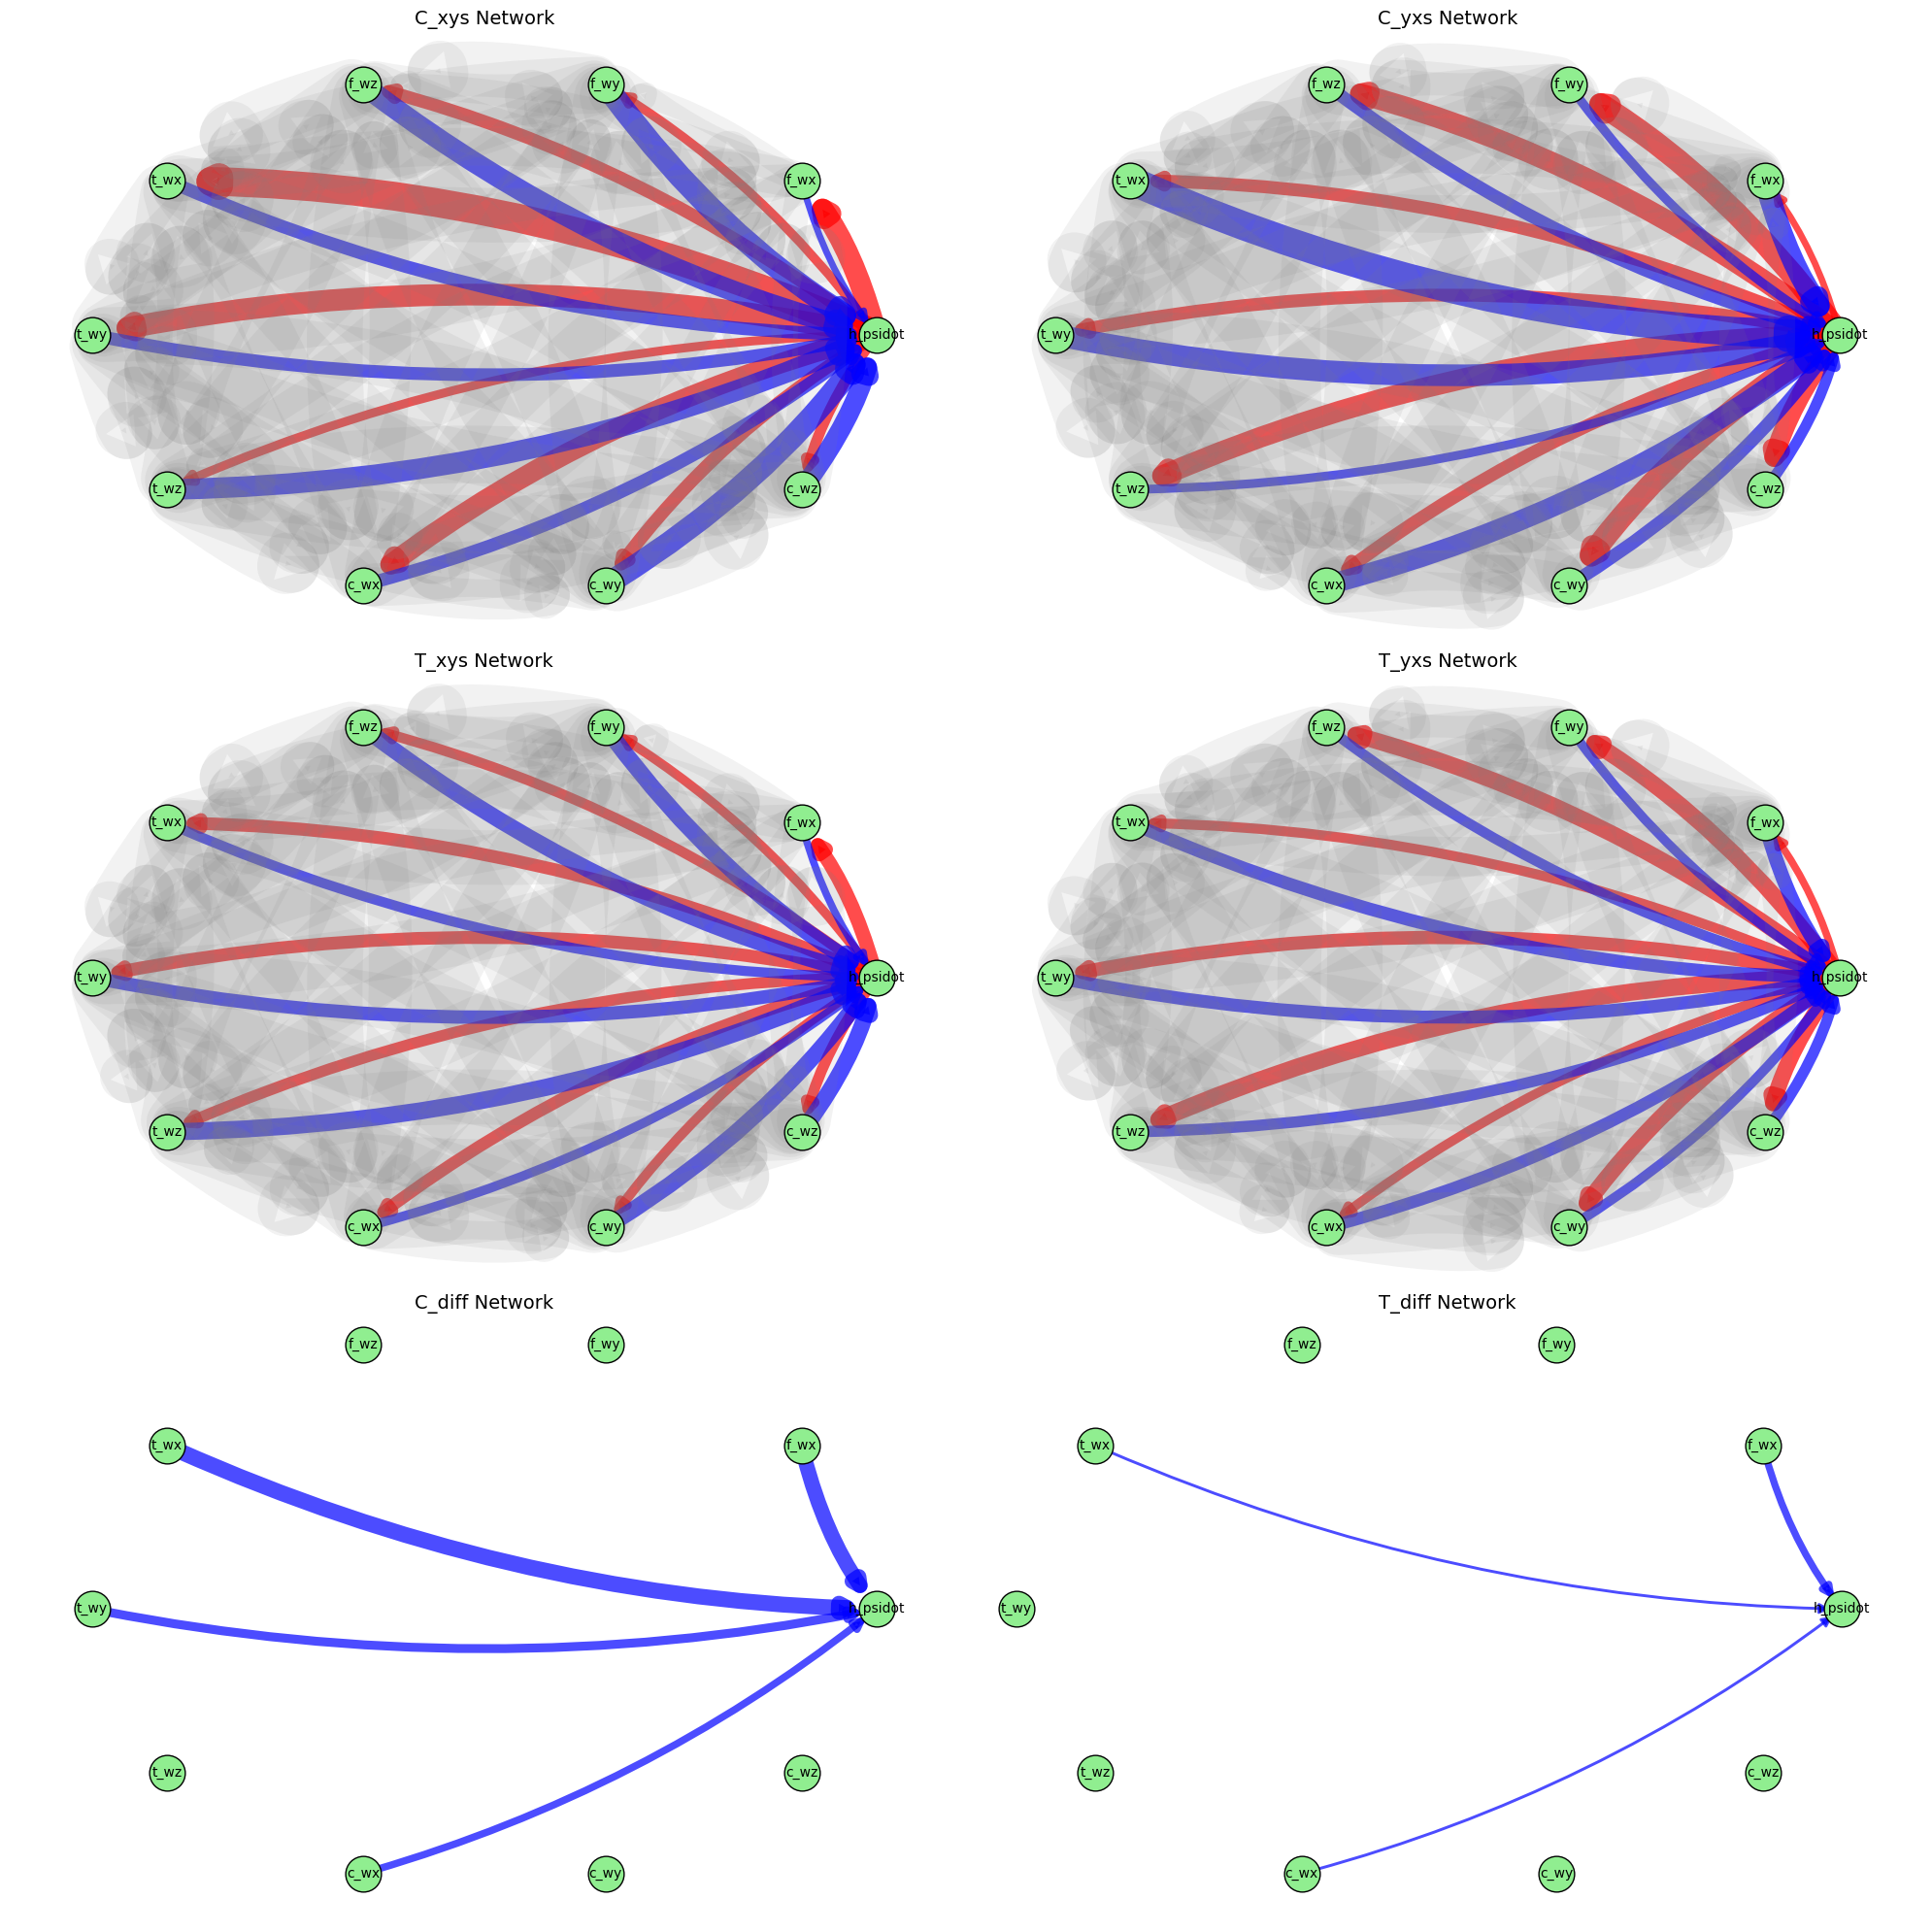

In [8]:


mapping = {
    0: "h_psidot",
    1: "f_wx", 2: "f_wy", 3: "f_wz",
    4: "t_wx", 5: "t_wy", 6: "t_wz", 
    7: "c_wx", 8: "c_wy", 9: "c_wz",   
}
target_nodes = ["h_psidot"]
width_scale = 50.0 

plot_rotation_networks(
    C_xys, C_yxs, T_xys, T_yxs,
    mapping,
    target_nodes=("h_psidot",),
    width_scale=50.0,
    savepath="network_visual_rotation_mix.pdf",
    figsize=(20, 20)
)

# Sliding Time Window

In [9]:
# --- GLOBAL PLOTTING CONFIGURATION (Variables used by both functions) ---

network_titles = ['C_xys Network', 'C_yxs Network', 'T_xys Network', 'T_yxs Network', 'C_diff', 'T_diff']
mapping = {
    0: "h_psidot", 
    1: "f_wx", 2: "f_wy", 3: "f_wz",
    4: "t_wx", 5: "t_wy", 6: "t_wz", 
    7: "c_wx", 8: "c_wy", 9: "c_wz"
}
target_nodes = ["h_psidot"]
width_scale = 5.0 


In [10]:
%%capture
print("this will not show")
C_xys_3D, C_yxs_3D, T_xys_3D, T_yxs_3D = get_sliding_window_animation(data, mapping, network_titles, width_scale, target_nodes, WINDOW_SIZE = 60, STEP_SIZE = 10)

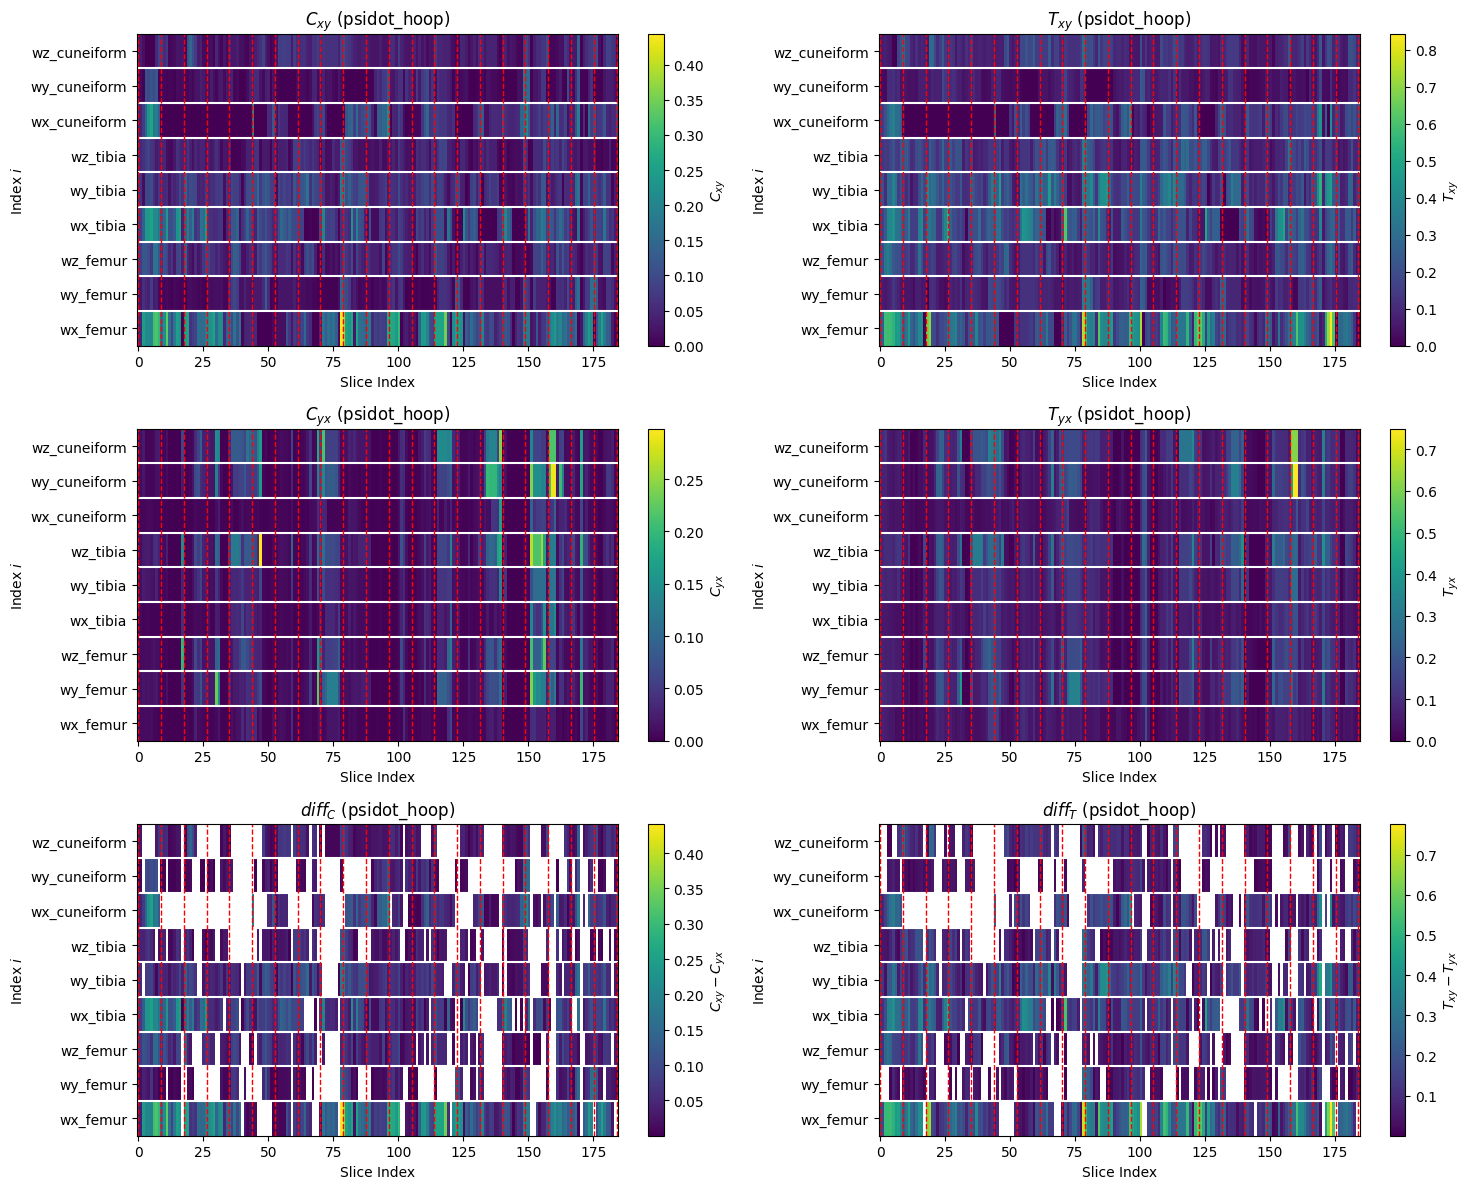

In [11]:
i_values = np.array([
    "wx_femur", "wy_femur", "wz_femur",
    "wx_tibia", "wy_tibia", "wz_tibia",
    "wx_cuneiform", "wy_cuneiform", "wz_cuneiform",
])

plot_rotation_heatmaps(
    C_xys_3D, C_yxs_3D, T_xys_3D, T_yxs_3D,
    i_start=1,
    i_end=10,
    i_values=i_values
)

In [12]:
names = [
    None,        # dummy so index matches i
    'femur_wx',
    'femur_wy',
    'femur_wz',
    'tibia_wx',
    'tibia_wy',
    'tibia_wz',
    'cuneiform_wx',
    'cuneiform_wy',
    'cuneiform_wz'
]

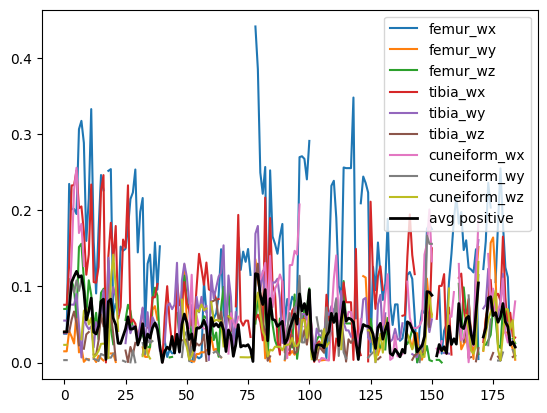

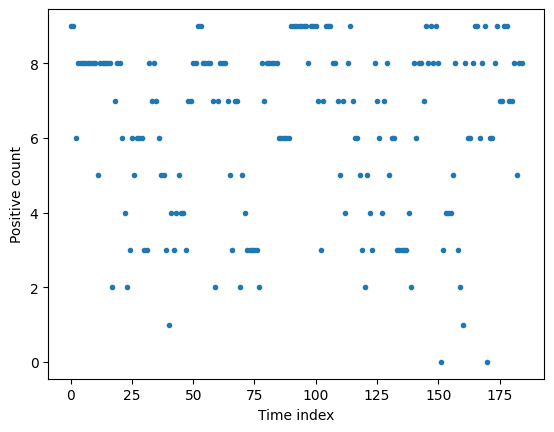

In [13]:
avg_positive, pos_count = plot_positive_directional_differences(
    C_xys_3D,
    names,
    i_start=1,
    i_end=10,
    normalize_by_count=False
)

In [ ]:
%%capture
print("this will not show")
C_xys_3D, C_yxs_3D, T_xys_3D, T_yxs_3D = get_sliding_window_animation(data, mapping, network_titles, width_scale, target_nodes, WINDOW_SIZE = 90, STEP_SIZE = 10)

# Animations

In [15]:
# # --- ANIMATION PARAMETERS ---
# TOTAL_TIME_POINTS = np.shape(data2[:500,:])[0]
# WINDOW_SIZE = 100    # Number of time points in the sliding window
# STEP_SIZE = 10        # How much the window shifts per frame (fewer steps = faster animation)
# FPS = 10             # Frames per second for the final GIF

# # Calculate the start indices for each frame
# start_indices = np.arange(0, TOTAL_TIME_POINTS - WINDOW_SIZE, STEP_SIZE)
# NUM_FRAMES = len(start_indices)

# # --- GLOBAL PLOTTING CONFIGURATION (from your code) ---
# network_titles = ['C_xys Network', 'C_yxs Network', 'T_xys Network', 'T_yxs Network']
# mapping = {
#     0: "h_wx", 1: "h_wy", 2: "h_wz", 3: "t_wx", 4: "t_wy", 5: "t_wz", 
#     6: "c_wx", 7: "c_wy", 8: "c_wz", 9: "f_wx", 10: "f_wy", 11: "f_wz"
# }
# target_nodes = ["h_wx", "h_wy", "h_wz"]
# width_scale = 5.0 

# # Prepare the figure and axes once
# fig, axes = plt.subplots(2, 2, figsize=(15, 15))
# axes_flat = axes.flatten()

# # Pre-calculate the fixed circular layout (should not change over time)
# # We use a dummy graph just to get the node ordering for the layout.
# dummy_G = nx.DiGraph(np.zeros((12, 12)))
# dummy_LG = nx.relabel_nodes(dummy_G, mapping)
# fixed_pos = nx.circular_layout(dummy_LG)

# # Define a single function to draw a network on a specific axis
# def draw_single_network(ax, network_data, title, pos, t_start):
#     """Draws a single network plot on the given axis."""
    
#     # Clear the previous drawing
#     ax.clear()
#     ax.axis('off') # Keep axis off after clearing
    
#     # --- Graph Creation and Relabeling ---
#     G = nx.DiGraph(network_data)
#     LG = nx.relabel_nodes(G, mapping)

#     # --- Separate Edges for Coloring ---
#     special_edgelist = []
#     special2_edgelist = []
#     other_edgelist = []
#     special_widths = []
#     special2_widths = []
#     other_widths = []

#     for u, v, data in LG.edges(data=True):
#         weight = data.get('weight', 0)
        
#         if weight > 0:
#             width = weight * width_scale
#             is_from_target = u in target_nodes
#             is_to_target = v in target_nodes
            
#             # Grouping logic (simplified)
#             if is_from_target:
#                 special_edgelist.append((u, v))
#                 special_widths.append(width)
#             elif is_to_target:
#                 special2_edgelist.append((u, v))
#                 special2_widths.append(width)
#             else:
#                 other_edgelist.append((u, v))
#                 other_widths.append(width)

#     # --- Draw the Network ---
    
#     # 1. Draw Nodes and Labels
#     nx.draw_networkx_nodes(LG, pos, node_size=700, node_color='lightgreen', edgecolors='black', ax=ax)
#     nx.draw_networkx_labels(LG, pos, font_size=10, font_color='black', ax=ax)

#     # 2. Draw Special Edges (FROM target_nodes - Red)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=special_edgelist, width=special_widths, 
#         edge_color='red', alpha=0.7, arrowsize=15, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # 3. Draw Special2 Edges (TO target_nodes - Blue)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=special2_edgelist, width=special2_widths, 
#         edge_color='blue', alpha=0.7, arrowsize=15, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # 4. Draw Other Edges (Gray)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=other_edgelist, width=other_widths, 
#         edge_color='gray', alpha=0.5, arrowsize=10, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # Set Title and time annotation
#     ax.set_title(f"{title}\nTime Window: {t_start}-{t_start + WINDOW_SIZE}", fontsize=12)

# # --- 2. The Update Function for the Animation ---
# def update(frame_index):
#     """
#     Function called by FuncAnimation for each frame.
#     It calculates the networks for a new time window and updates the plots.
#     """
#     t_start = start_indices[frame_index]
#     t_end = t_start + WINDOW_SIZE
    
#     # 1. Slice the data for the current window
#     data_window = data2[t_start:t_end, :]

#     # 2. Calculate the four networks
#     # The output is (C_xys, C_yxs, T_xys, T_yxs) as per your setup

#     G, G_, common_G, C_xys, C_yxs, T_xys, T_yxs, rrx, rrxy = compute_functional_network_th(data_window,th=(0.1, 0.1, 0.05), n=np.shape(data_angle_derivatives)[1] )
    

#     # G, G_, common_G, T_diff, C_diff, C_xys, C_yxs, T_xys, T_yxs = compute_functional_network(
#     #     data_window, 
#     #     (0.06, 0.06, 0.02), 
#     #     C_threshold=0.02, 
#     #     T_threshold=0.02, 
#     #     n=np.shape(data)[1]
#     # )

#     networks_data = [C_xys, C_yxs, T_xys, T_yxs]
#     print(np.shape(networks_data))

#     # 3. Redraw all four subplots
#     for i in range(4):
#         ax = axes_flat[i]
#         network_data = networks_data[i]
#         title = network_titles[i]
        
#         draw_single_network(ax, network_data, title, fixed_pos, t_start)
    
#     # Return the updated artists (necessary for FuncAnimation)
#     return axes_flat

# # --- 3. Run and Save the Animation ---
# print(f"Generating animation with {NUM_FRAMES} frames...")

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=NUM_FRAMES,
#     blit=False,  # Set to False, as NetworkX often doesn't handle blitting well
#     interval=1000/FPS # Delay between frames in ms
# )

# # Set the save path
# animation_filename = 'network_evolution.gif'

# # Save the animation as a GIF
# writer = PillowWriter(fps=FPS)
# anim.save(animation_filename, writer=writer)

# plt.close(fig) # Close the figure to free up memory
# print(f"Animation saved as {animation_filename}")

In [16]:
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter
# import os # For saving the GIF

# # --- ANIMATION PARAMETERS ---
# TOTAL_TIME_POINTS = np.shape(data_angle_derivatives)[0]
# WINDOW_SIZE = 100    # Number of time points in the sliding window
# STEP_SIZE = 5        # How much the window shifts per frame (fewer steps = faster animation)
# FPS = 10             # Frames per second for the final GIF

# # Calculate the start indices for each frame
# start_indices = np.arange(0, TOTAL_TIME_POINTS - WINDOW_SIZE, STEP_SIZE)
# NUM_FRAMES = len(start_indices)

# # --- GLOBAL PLOTTING CONFIGURATION (from your code) ---
# network_titles = ['C_xys Network', 'C_yxs Network', 'T_xys Network', 'T_yxs Network']
# mapping = {
#     0: "h_wx", 1: "h_wy", 2: "h_wz", 3: "t_wx", 4: "t_wy", 5: "t_wz", 
#     6: "c_wx", 7: "c_wy", 8: "c_wz", 9: "f_wx", 10: "f_wy", 11: "f_wz"
# }
# target_nodes = ["h_wx", "h_wy", "h_wz"]
# width_scale = 5.0 

# # Prepare the figure and axes once
# fig, axes = plt.subplots(2, 2, figsize=(15, 15))
# axes_flat = axes.flatten()

# # Pre-calculate the fixed circular layout (should not change over time)
# # We use a dummy graph just to get the node ordering for the layout.
# dummy_G = nx.DiGraph(np.zeros((12, 12)))
# dummy_LG = nx.relabel_nodes(dummy_G, mapping)
# fixed_pos = nx.circular_layout(dummy_LG)

# # Define a single function to draw a network on a specific axis
# def draw_single_network(ax, network_data, title, pos, t_start):
#     """Draws a single network plot on the given axis."""
    
#     # Clear the previous drawing
#     ax.clear()
#     ax.axis('off') # Keep axis off after clearing
    
#     # --- Graph Creation and Relabeling ---
#     G = nx.DiGraph(network_data)
#     LG = nx.relabel_nodes(G, mapping)

#     # --- Separate Edges for Coloring ---
#     special_edgelist = []
#     special2_edgelist = []
#     other_edgelist = []
#     special_widths = []
#     special2_widths = []
#     other_widths = []

#     for u, v, data in LG.edges(data=True):
#         weight = data.get('weight', 0)
        
#         if weight > 0:
#             width = weight * width_scale
#             is_from_target = u in target_nodes
#             is_to_target = v in target_nodes
            
#             # Grouping logic (simplified)
#             if is_from_target:
#                 special_edgelist.append((u, v))
#                 special_widths.append(width)
#             elif is_to_target:
#                 special2_edgelist.append((u, v))
#                 special2_widths.append(width)
#             else:
#                 other_edgelist.append((u, v))
#                 other_widths.append(width)

#     # --- Draw the Network ---
    
#     # 1. Draw Nodes and Labels
#     nx.draw_networkx_nodes(LG, pos, node_size=700, node_color='lightgreen', edgecolors='black', ax=ax)
#     nx.draw_networkx_labels(LG, pos, font_size=10, font_color='black', ax=ax)

#     # 2. Draw Special Edges (FROM target_nodes - Red)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=special_edgelist, width=special_widths, 
#         edge_color='red', alpha=0.7, arrowsize=15, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # 3. Draw Special2 Edges (TO target_nodes - Blue)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=special2_edgelist, width=special2_widths, 
#         edge_color='blue', alpha=0.7, arrowsize=15, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # 4. Draw Other Edges (Gray)
#     nx.draw_networkx_edges(
#         LG, pos, edgelist=other_edgelist, width=other_widths, 
#         edge_color='gray', alpha=0.5, arrowsize=10, 
#         connectionstyle='arc3,rad=0.1', ax=ax
#     )

#     # Set Title and time annotation
#     ax.set_title(f"{title}\nTime Window: {t_start}-{t_start + WINDOW_SIZE}", fontsize=12)

# # --- 2. The Update Function for the Animation ---
# def update(frame_index):
#     """
#     Function called by FuncAnimation for each frame.
#     It calculates the networks for a new time window and updates the plots.
#     """
#     t_start = start_indices[frame_index]
#     t_end = t_start + WINDOW_SIZE
    
#     # 1. Slice the data for the current window
#     data_window = data_angle_derivatives[t_start:t_end, :]

#     # 2. Calculate the four networks
#     # The output is (C_xys, C_yxs, T_xys, T_yxs) as per your setup
#     C_xys, C_yxs, T_xys, T_yxs = compute_functional_network(
#         data_window, 
#         (0.06, 0.06, 0.02), 
#         C_threshold=0.02, 
#         T_threshold=0.02, 
#         n=10
#     )
    
#     networks_data = [C_xys, C_yxs, T_xys, T_yxs]

#     # 3. Redraw all four subplots
#     for i in range(4):
#         ax = axes_flat[i]
#         network_data = networks_data[i]
#         title = network_titles[i]
        
#         draw_single_network(ax, network_data, title, fixed_pos, t_start)
    
#     # Return the updated artists (necessary for FuncAnimation)
#     return axes_flat

# # --- 3. Run and Save the Animation ---
# print(f"Generating animation with {NUM_FRAMES} frames...")

# anim = FuncAnimation(
#     fig, 
#     update, 
#     frames=NUM_FRAMES,
#     blit=False,  # Set to False, as NetworkX often doesn't handle blitting well
#     interval=1000/FPS # Delay between frames in ms
# )

# # Set the save path
# animation_filename = 'network_evolution.gif'

# # Save the animation as a GIF
# writer = PillowWriter(fps=FPS)
# anim.save(animation_filename, writer=writer)

# plt.close(fig) # Close the figure to free up memory
# print(f"Animation saved as {animation_filename}")

In [17]:
# import numpy as np
# import networkx as nx
# import matplotlib.pyplot as plt
# from matplotlib.animation import FuncAnimation, PillowWriter

# # --- PARAMETERS ---
# TOTAL_TIME_POINTS = np.shape(data_angle_derivatives)[0]
# WINDOW_SIZE = 100
# STEP_SIZE = 5
# FPS = 10

# start_indices = np.arange(0, TOTAL_TIME_POINTS - WINDOW_SIZE, STEP_SIZE)
# NUM_FRAMES = len(start_indices)

# mapping = {0: "h_wx", 1: "h_wy", 2: "h_wz", 3: "t_wx", 4: "t_wy", 5: "t_wz",
#            6: "c_wx", 7: "c_wy", 8: "c_wz", 9: "f_wx", 10: "f_wy", 11: "f_wz"}
# target_nodes = ["h_wx", "h_wy", "h_wz"]

# # --- RECORD HOOP CONNECTIONS ---
# C_xys_hoop_series = []
# T_xys_hoop_series = []

# # --- FUNCTION TO EXTRACT HOOP CONNECTION VALUES ---
# def extract_hoop_connections(matrix):
#     """
#     Extract all rows/columns corresponding to hoop nodes (target_nodes)
#     and flatten them into a single vector of values.
#     """
#     indices = [k for k, v in mapping.items() if v in target_nodes]
#     # Take all connections from/to hoop nodes
#     hoop_values = matrix[indices, :].flatten()
#     hoop_values = np.append(hoop_values, matrix[:, indices].flatten())
#     return hoop_values

# # --- ANIMATION UPDATE FUNCTION ---
# def update(frame_index):
#     t_start = start_indices[frame_index]
#     t_end = t_start + WINDOW_SIZE
#     data_window = data_angle_derivatives[t_start:t_end, :]

#     C_xys, C_yxs, T_xys, T_yxs = compute_functional_network(
#         data_window, (0.06, 0.06, 0.02), C_threshold=0.02, T_threshold=0.02, n=np.shape(data_angle_derivatives)[1]
#     )

#     # Record hoop connection values
#     C_xys_hoop_series.append(extract_hoop_connections(C_xys))
#     T_xys_hoop_series.append(extract_hoop_connections(T_xys))

#     # --- OPTIONAL: draw animation frames if needed ---
#     return []

# # --- RUN ANIMATION TO COLLECT DATA ---
# for i in range(NUM_FRAMES):
#     update(i)

# # Convert to arrays: rows = time windows, columns = different hoop connections
# C_xys_hoop_series = np.array(C_xys_hoop_series)
# T_xys_hoop_series = np.array(T_xys_hoop_series)

# # --- PLOT TIME SERIES ---
# time_windows = start_indices
# plt.figure(figsize=(12, 6))
# plt.plot(time_windows, C_xys_hoop_series.mean(axis=1), label='C_xys (hoop connections)')
# plt.plot(time_windows, T_xys_hoop_series.mean(axis=1), label='T_xys (hoop connections)')
# plt.xlabel("Time window start index")
# plt.ylabel("Average connection weight")
# plt.title("Time series of C_xys and T_xys connecting to hoop nodes")
# plt.legend()
# plt.grid(True)
# plt.show()
